# 1 Part

In [1]:
from melbanks import LogMelFilterBanks
import torch
import torchaudio

In [2]:
signal, sr = torchaudio.load("/home/darinka/Downloads/My Little Black Angel Death In June.wav")

In [3]:
melspec = torchaudio.transforms.MelSpectrogram(
    hop_length=160,
    n_mels=80
)(signal)
logmelbanks = LogMelFilterBanks()(signal)
log_melspec = torch.log(melspec + 1e-6)

assert log_melspec.shape == logmelbanks.shape
assert torch.allclose(log_melspec, logmelbanks)

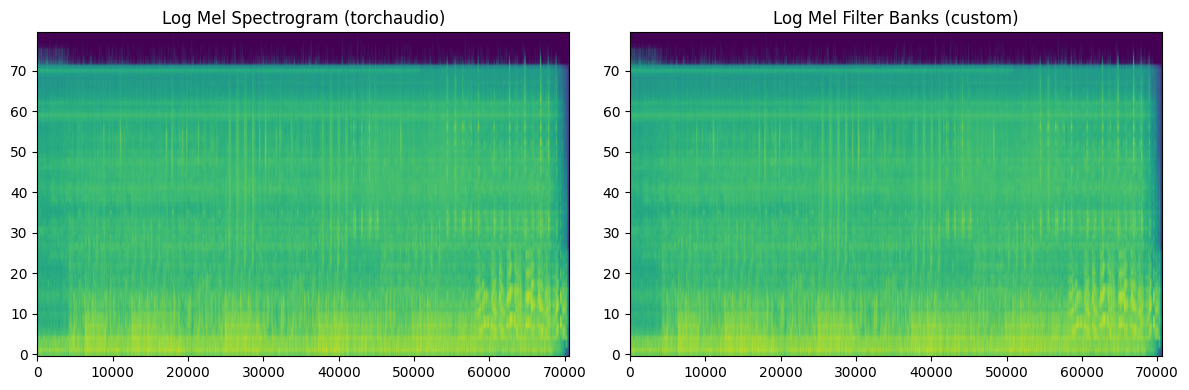

In [ ]:
import matplotlib.pyplot as plt

log_melspec_np = log_melspec[0].cpu().numpy()
logmelbanks_np = logmelbanks[0].cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(log_melspec_np, origin="lower", aspect="auto")
axs[0].set_title("Log Mel Spectrogram")

axs[1].imshow(logmelbanks_np, origin="lower", aspect="auto")
axs[1].set_title("Log Mel Filter Banks")

plt.tight_layout()
plt.show()

# 2 Part

In [5]:
from cnn import BinarySpeechCommands, SpeechCommandBinaryClassifier, collate_fn
import pytorch_lightning as pl
from torch.utils.data import DataLoader


train_dataset = BinarySpeechCommands(subset="training")
val_dataset = BinarySpeechCommands(subset="validation")
test_dataset = BinarySpeechCommands(subset="testing")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

/home/darinka/projects/ai-talent-hub-itmo-speech-course/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
train_dataset[0][0].shape

torch.Size([16000])

In [ ]:
model = SpeechCommandBinaryClassifier(lr=1e-3)
_ = model.compute_flops(input_size=(1, train_dataset[0][0].shape[0]))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
CNN FLOPs: 1782720.0   MACs: 891360.0   Params: 10898.0 



In [ ]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)